# Imbalanced Data Case
### Royer Ticse Torres, Dec. 2019


This notebook is an analysis in python step-by-step. Starting from raw data to making a binary classification model in an imbalanced dataset.

![title](imbalancedData.jpg "Header")

# Dive into data
First things first!. Understand the content of the data

In [122]:
import numpy as np
import pandas as pd
import scipy
import os.path
import json
from pandas import Series, DataFrame
from dateutil.parser import parse
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn import metrics 
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform
#from sklearn.externals import joblib
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from IPython.display import Image  
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize
from sklearn.utils import shuffle
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier, Pool
from imblearn.over_sampling import SMOTE
import itertools

from scipy import interp
from os import path
from itertools import cycle
import seaborn as sb
import matplotlib.pyplot as plt
from pylab import rcParams
import pydotplus
import graphviz 

%matplotlib inline
rcParams['figure.figsize'] = 14, 7
sb.set_style('whitegrid')

In [2]:
# reading the training data
address = 'datasets/training_grover.csv'
df_meta = pd.read_csv(address, sep=';', index_col=0)

In [3]:
df_meta.head()

,x.0,x.1,x.2,x.3,x.4,x.5,x.6,x.7,x.8,x.9,...,x.11,x.12,x.13,x.14,x.20,x.17,x.18,x.19,x.16,y
0,b,"30,83",f,u,g,w,v,1.25,t,t,...,f,g,202.0,f,t,"116,94256980957068","0,5787085579422866",202000.0,f,good
1,a,"58,67",4.46,u,g,q,h,3.04,t,t,...,f,g,43.0,560,t,"225,60625307204938","25,409645364400404",43000.0,f,good
2,a,"24,5",0.5,u,g,q,h,1.5,t,f,...,f,g,280.0,824,t,"92,08407670672422","2,3173371593153314",280000.0,f,good
3,b,"27,83",1.54,u,g,w,v,3.75,t,t,...,t,g,100.0,3,t,"104,16291777029285","8,04533772976642",100000.0,f,good
4,b,"20,17",5.625,u,g,w,v,1.71,t,f,...,f,s,120.0,f,t,"77,8703024439662","31,111460957322073",120000.0,f,good


Can be differentiate numeric features and categorical features

In [4]:
cat_features = ['x.0', 'x.3', 'x.4', 'x.5', 'x.6', 'x.8', 'x.9', 'x.11', 'x.12', 'x.20', 'x.16' ,'y']
num_features = ['x.1','x.2', 'x.7', 'x.10', 'x.13', 'x.14', 'x.17', 'x.19', 'x.18'] 

Target distribution

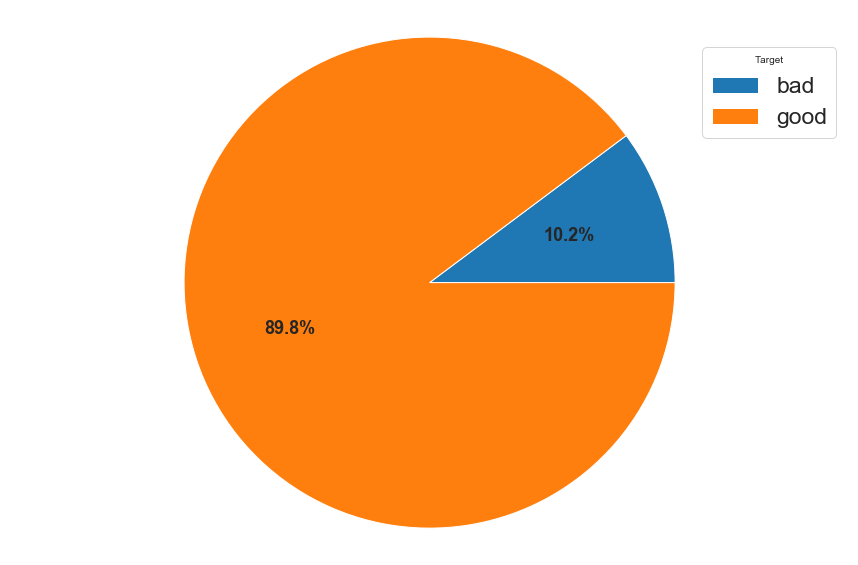

In [89]:
labels = df_meta['y'].astype('category').cat.categories.tolist()
counts = df_meta['y'].value_counts()
sizes = [counts[var_cat] for var_cat in labels]
fig1, ax1 = plt.subplots()
wedges, texts, autotexts  = ax1.pie(sizes, labels=None, autopct='%1.1f%%', shadow=False)
ax1.axis('equal')
plt.rcParams["figure.figsize"] = 15,10
plt.setp(autotexts, size=18, weight="bold")
ax1.legend(wedges, labels,
          title="Target",
          loc="right", prop={'size': 23},
         bbox_to_anchor=(1, 0.85, 0.0, 0.))
#plt.savefig('target.png', bbox_inches='tight', pad_inches=0.0)

## Numeric features

In [6]:
def count_non_num_values(df_num, num_features):
    df = pd.DataFrame()
    list_name = ["f", "t", "?", "Total"]
    list_count = []
    for item in num_features:
        v1 = df_num[item].loc[df_num[item]=='f'].count()
        v2 = df_num[item].loc[df_num[item]=='t'].count()
        v3 = df_num[item].loc[df_num[item]=='?'].count()
        df[item] = [v1, v2, v3, v1+v2+v3]
    df["value"]= list_name
    df= df.set_index("value")
    return df

In [7]:
def replace_values(df_num, num_features):
    #df_num = pd.DataFrame()
    #df_num = data[num_features]
    for sr in num_features:
        df_num.loc[df_num[sr] == "?",  sr] = '-9,0'
        df_num.loc[df_num[sr] == "f",  sr] = '-9,0'
        df_num.loc[df_num[sr] == "t",  sr] = '-9,0'
        df_num[sr] = df_num[sr].str.replace(",",".").astype(float)
    return df_num

In [8]:
def imputer_num_data(df, num_features):
    
    imputer=SimpleImputer(missing_values=-9.0,strategy='mean')
    imputer=imputer.fit(df[num_features])
    df[num_features]=imputer.transform(df[num_features])

    return df

In [9]:
def plot(name):
    plt.figure(figsize=[10,8])
    n, bins, patches = plt.hist(data_num[name], bins=50, color='#0456aa',alpha=0.7, rwidth=0.85)
    plt.grid(axis='y', alpha=0.75)
    plt.xlabel(name,fontsize=20)
    #plt.ylabel('Frequency',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.title(name,fontsize=20)
    fig = plt.gcf()
    #fig.savefig(name+".png")
    plt.show()
    return bins

In [10]:
data_num= df_meta[num_features].copy()

### missing values
Considering $f$, $t$ and $?$ as missing values

In [11]:
count_non_num_values(data_num, num_features)

,x.1,x.2,x.7,x.10,x.13,x.14,x.17,x.19,x.18
value,,,,,,,,,
f,0,73,139,1009,658,1050,0,658,0
t,0,52,55,296,0,31,0,0,0
?,9,0,0,0,52,0,9,52,0
Total,9,125,194,1305,710,1081,9,710,0


In [12]:
data_num = replace_values(data_num, num_features)

Impute the mean, for features with missing values less than 200. 

In [13]:
imp_num_fs = ['x.1','x.2', 'x.7', 'x.17'] 

In [14]:
data_num = imputer_num_data(data_num, imp_num_fs )

Let's plot a histogram for each numerical attribute.

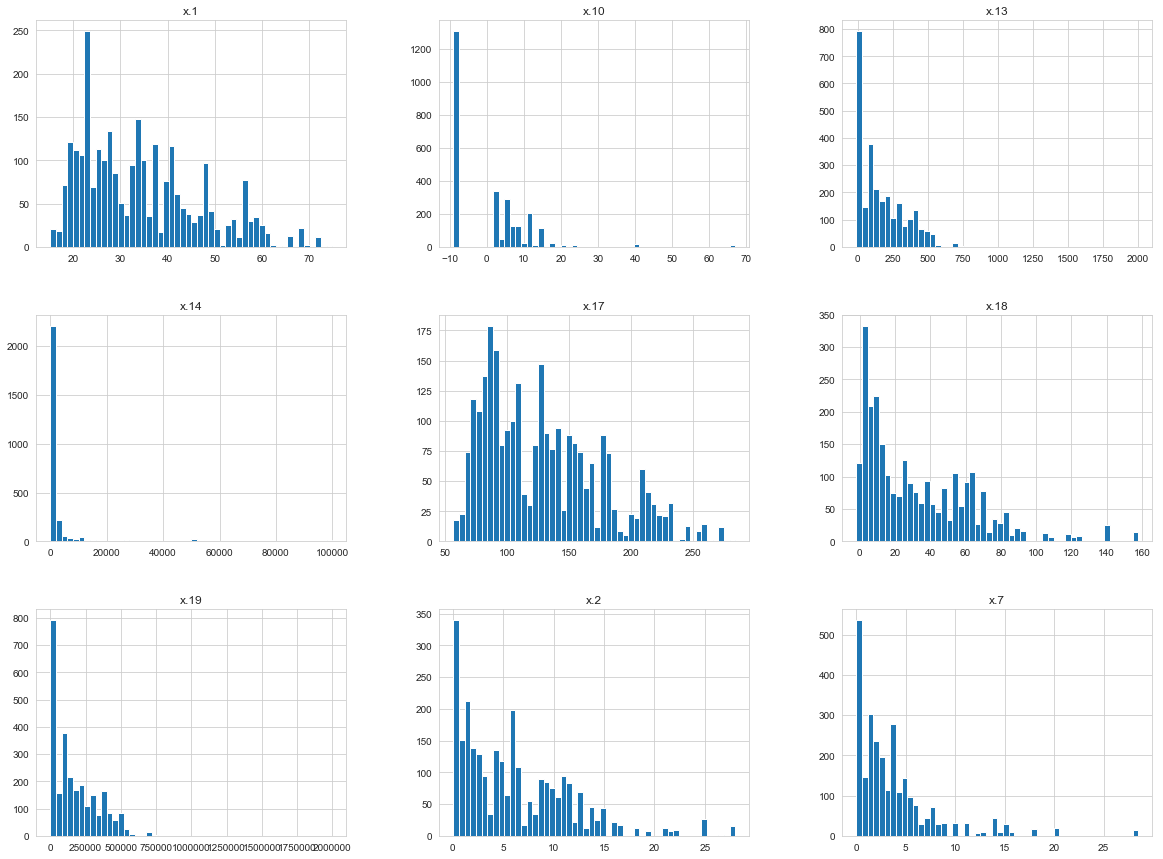

In [15]:
data_num.hist(bins=50, figsize=(20,15))
fig = plt.gcf()
#fig.savefig("vars.png")
plt.show()

Let's do the correlation analysis. During this step we are cheking how features related to each other.

In [16]:
corr_m = data_num.corr()

[Text(0, 0.5, 'x.1'),
 Text(0, 1.5, 'x.2'),
 Text(0, 2.5, 'x.7'),
 Text(0, 3.5, 'x.10'),
 Text(0, 4.5, 'x.13'),
 Text(0, 5.5, 'x.14'),
 Text(0, 6.5, 'x.17'),
 Text(0, 7.5, 'x.19'),
 Text(0, 8.5, 'x.18')]

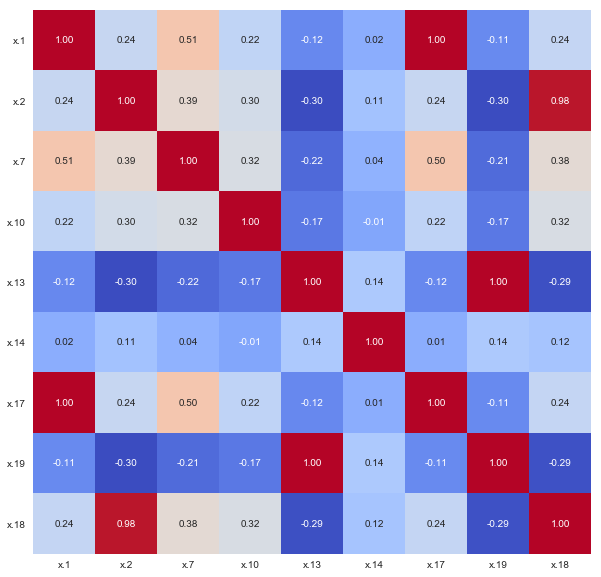

In [17]:
fig, ax = plt.subplots()
fig.set_size_inches(10,10)
sb.heatmap(corr_m, annot=True, fmt='.2f', 
            cmap=plt.get_cmap('coolwarm'), cbar=False, ax=ax)
ax.set_yticklabels(ax.get_yticklabels(), rotation="horizontal")
#plt.savefig('corr.png', bbox_inches='tight', pad_inches=0.0)

We can see a high correlation between 3 pairs of features. Thus we will drop: $x.2$, $x.17$ and $x.19$

## Categorical features

In [18]:
def count_non_cat_values(df_cat, cat_features):
    df = pd.DataFrame()
    list_name = ["?"]
    list_count = []
    for item in cat_features:
        v3 = df_cat[item].loc[df_cat[item]=='?'].count()
        df[item] = [v3]
    df["value"]= list_name
    df= df.set_index("value")
    return df

In [19]:
def print_cats(df, cat_features):
    for item in cat_features:
        print("categories for feature: "+item)
        print(data_cat[item].value_counts())
              
    return print('done')

In [20]:
def plot_cat_var(data, y, hue):
    fig, b = plt.subplots()
    fig.set_size_inches(10,8)
    b = sb.countplot(y=y, hue=hue, data=data)
    b.set_xlabel("count",fontsize=14)
    b.set_ylabel("y",fontsize=14)
    b.tick_params(labelsize=14)
    plt.setp(b.get_legend().get_texts(), fontsize='18') 
    plt.setp(b.get_legend().get_title(), fontsize='18')
    plt.title(hue,fontsize=20)
    #fig.savefig(hue+".png")
    plt.show()
    return b

In [21]:
data_cat = df_meta[cat_features]


In [22]:
#print_cats(data_cat, cat_features)

### missing values
Considering "$?$" as missing value.

In [23]:
count_non_cat_values(data_cat, cat_features)

,x.0,x.3,x.4,x.5,x.6,x.8,x.9,x.11,x.12,x.20,x.16,y
value,,,,,,,,,,,,
?,15,24,24,25,25,0,0,0,0,2180,668,0


x.20 has 82% (2180) of its values as ”?”. We can drop it

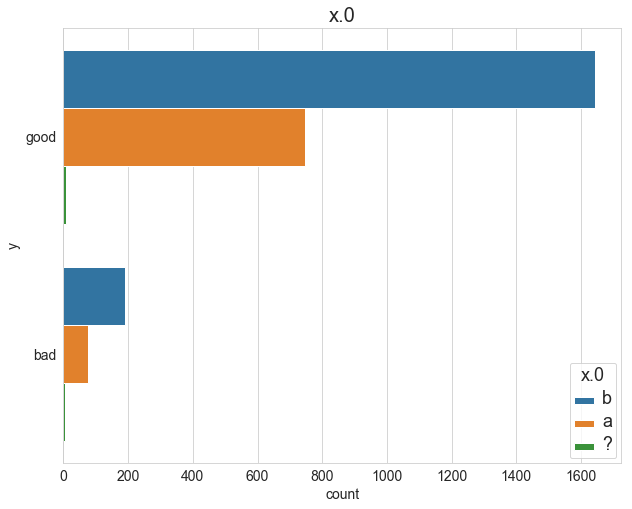

In [24]:
plot_cat_var(data_cat, 'y', 'x.0')

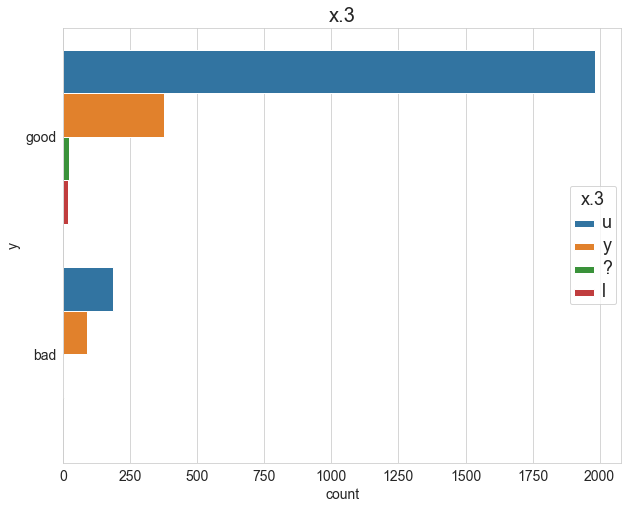

In [25]:
plot_cat_var(data_cat, 'y', 'x.3')

$x.3$ and $x.4$ look exactly the same feature.

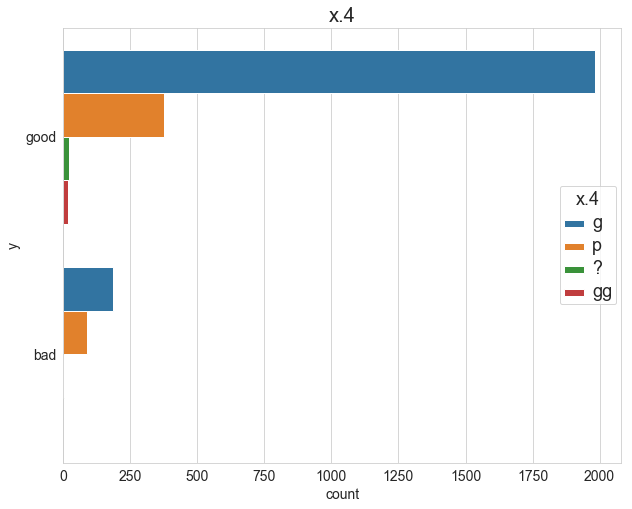

In [26]:
plot_cat_var(data_cat, 'y', 'x.4')

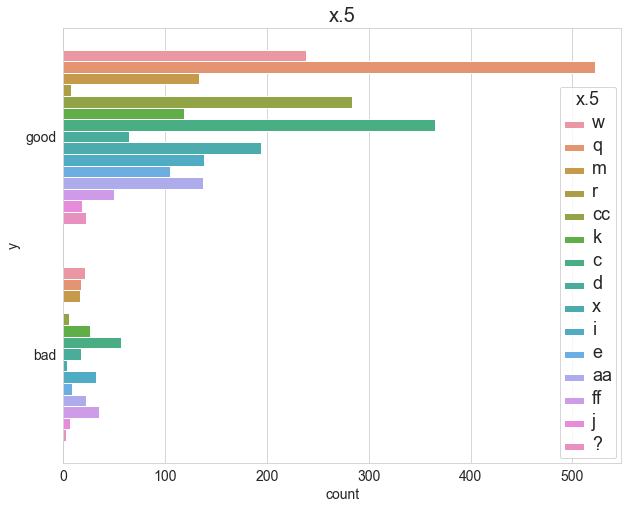

In [27]:
plot_cat_var(data_cat, 'y', 'x.5')

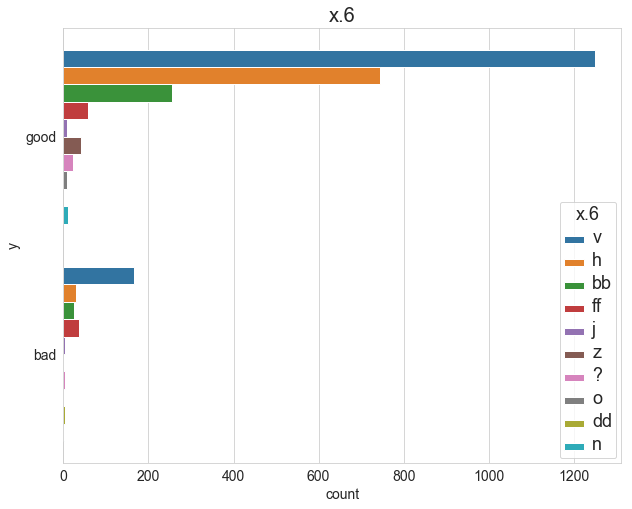

In [28]:
plot_cat_var(data_cat, 'y', 'x.6')

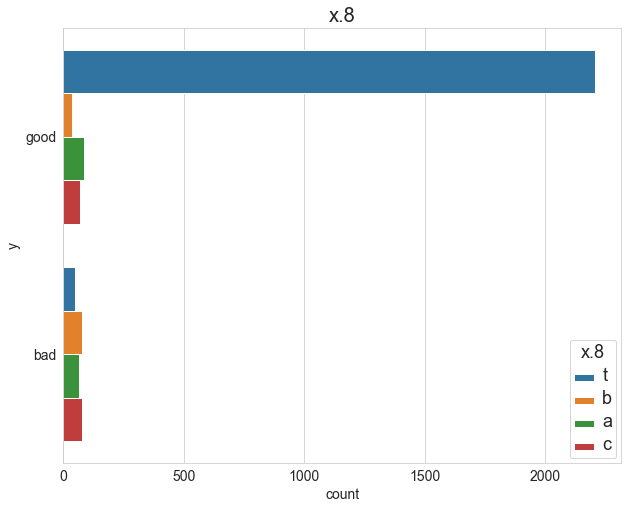

In [29]:
plot_cat_var(data_cat, 'y', 'x.8')

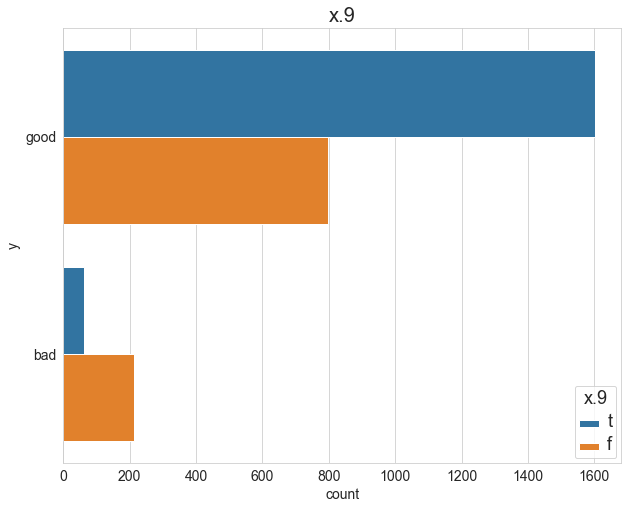

In [30]:
plot_cat_var(data_cat, 'y', 'x.9')

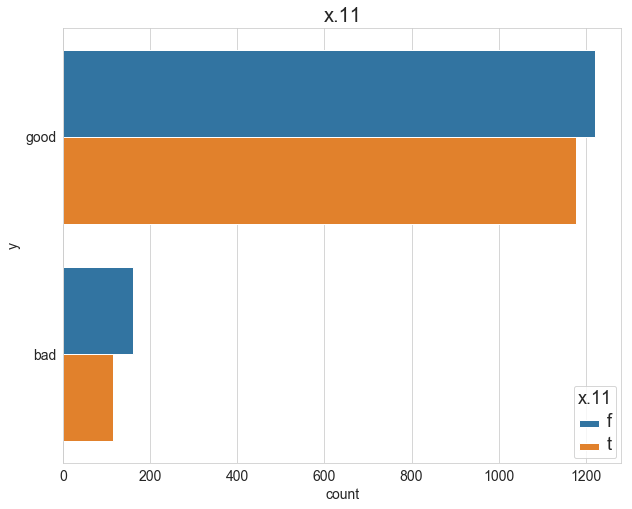

In [31]:
plot_cat_var(data_cat, 'y', 'x.11')

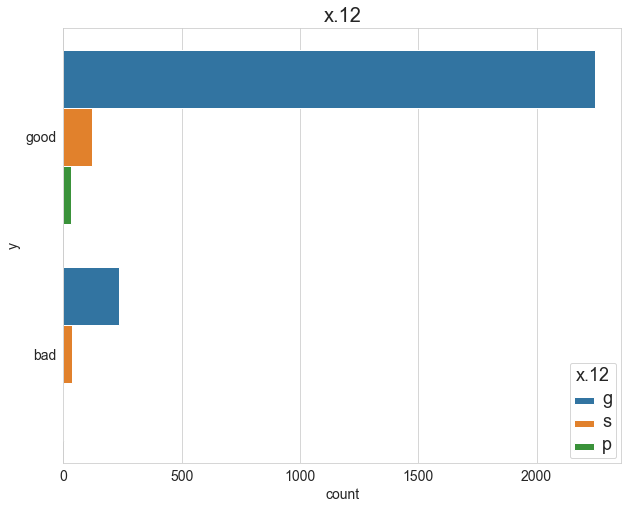

In [32]:
plot_cat_var(data_cat, 'y', 'x.12')

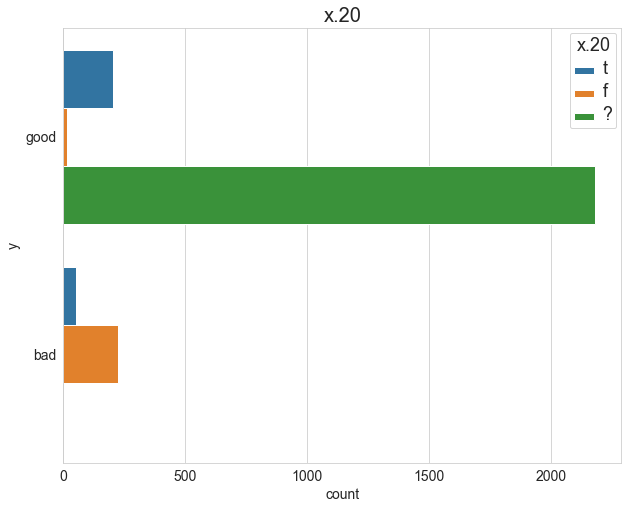

In [33]:
plot_cat_var(data_cat, 'y', 'x.20') # too many "?" values

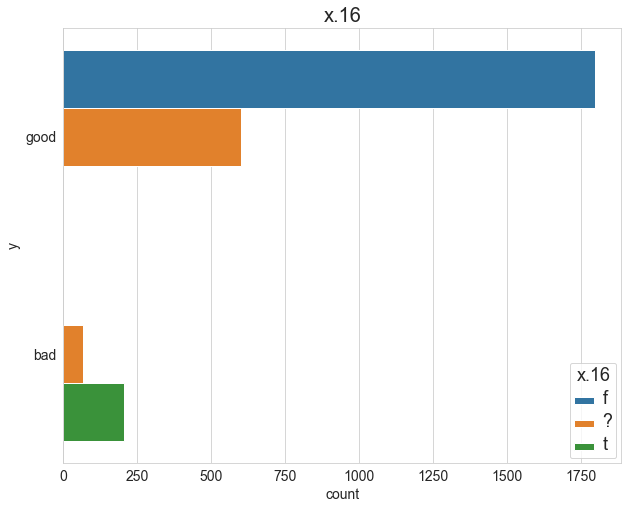

In [34]:
plot_cat_var(data_cat, 'y', 'x.16')

Categorical features to drop: $x.4$ and $x.20$

# Making a classification model

The proposed models is based on Decision Trees machine learning technique. Only selected features are considering for training the models.

In [35]:
# training data
data = df_meta.copy()

In [36]:
#selected features for training
sel_cat_fs = ['x.0', 'x.3', 'x.5', 'x.6', 'x.8', 'x.9', 'x.11', 'x.12', 'x.16','y']
sel_num_fs = ['x.1', 'x.7', 'x.10', 'x.13', 'x.14', 'x.18'] 

#replace missing values with the mean in:
imp_num_fs = ['x.1', 'x.7'] 

In [37]:
def clean_data(data):
    data = data.drop(['x.2'], axis=1)
    data = data.drop(['x.17'], axis=1)
    data = data.drop(['x.19'], axis=1)
    data = data.drop(['x.4'], axis=1)
    data = data.drop(['x.20'], axis=1)
    return data

In [38]:
def fill_missing_num_val(data, columns):
    for sr in columns:
        data.loc[data[sr] == "?",  sr] = '-9,0'
        data.loc[data[sr] == "f",  sr] = '-9,0'
        data.loc[data[sr] == "t",  sr] = '-9,0'
        data[sr] = data[sr].str.replace(",",".").astype(float)
    return data

In [39]:
def prepare_data(df, cat_features, num_features ):
    # Label encoding
    encoder = LabelEncoder()
    encoded = df[cat_features].apply(encoder.fit_transform)

    df = df.drop(cat_features, axis=1)
    df = df.join(encoded)
    # imputer missing values
    imputer=SimpleImputer(missing_values=-9.0,strategy='mean')
    imputer=imputer.fit(df[num_features])
    df[num_features]=imputer.transform(df[num_features])
    
    df = shuffle(df)
    X = df.drop(['y'], axis=1)
    y = df['y']
    return X,y

In [40]:
data = clean_data(data)

In [41]:
data = fill_missing_num_val(data, sel_num_fs)

In [42]:
X, y = prepare_data(data, sel_cat_fs, imp_num_fs )

In [43]:
X.head()

,x.1,x.7,x.10,x.13,x.14,x.18,x.0,x.3,x.5,x.6,x.8,x.9,x.11,x.12,x.16
1598,45.83,5.000,7.0,-9.0,-9.0,58.651720,1,2,11,8,3,1,1,0,1
956,40.83,1.750,-9.0,29.0,837.0,55.309305,1,2,11,4,3,0,0,0,1
275,18.58,0.540,-9.0,120.0,-9.0,30.308567,2,2,4,8,2,0,0,0,2
1869,26.67,4.290,-9.0,120.0,-9.0,22.578949,2,2,3,8,3,1,1,0,0
1188,53.92,8.665,5.0,-9.0,-9.0,52.664101,2,2,5,8,3,1,0,0,0


In [44]:
y.value_counts()

1    2398
0     273
Name: y, dtype: int64

### Using oversampling SMOTE
From the SMOTE class from the imblearn library. 

In [45]:
smt = SMOTE()
X_train, y_train = smt.fit_sample(X, y)

In [46]:
y_train.value_counts()

1    2398
0    2398
Name: y, dtype: int64

### Processing valindation dataset
Doing the same procedure on the validation dataset except for the SMOTE step. 

Note. I made some mistakes in preprocessing the validation set. Shouldn't have fit an imputer for missing values and apply fit_transform() for the label encoder on the validation set. I just realized after submit. Sorry about that.$

In [47]:
# reading the validation data
address = 'datasets/validation_grover.csv'
df_val = pd.read_csv(address, sep=';', index_col=0)

In [48]:
df_val= clean_data(df_val)

In [49]:
df_val = fill_missing_num_val(df_val, sel_num_fs)

In [50]:
X_val, y_val = prepare_data(df_val, sel_cat_fs, imp_num_fs )

In [51]:
y_val.value_counts()

0    336
1    154
Name: y, dtype: int64

## Tree-based models

Tree-based classifiers are not sensitive to outliers and noise, thus it is very suitable for the classification of the dataset. The models would be able to learn the patterns and make a binary classification.

Small learning rate and large number of estimators are used in the classifiers. 
Limiting max_depth=10 will regularize the model.

In [120]:
def plot_confusion_matrix(y_true, y_pred, normalize=False, title=None, cmap=plt.cm.Blues):

    cm = confusion_matrix(y_true, y_pred)
    classes = unique_labels(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    fig.set_size_inches(7,7)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           ylabel='True label', xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=0, ha="right", rotation_mode="anchor")
    plt.title(title,fontsize=14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize=16, horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    fig.tight_layout()
    #fig.savefig(title+"_cm.png")
    return ax

In [53]:
def auc_val(m, X_train, X_val): 
    return (metrics.roc_auc_score(y_train,m.predict_proba(X_train)[:,1]),
                            metrics.roc_auc_score(y_val,m.predict_proba(X_val)[:,1]))

In [54]:
def auc_val_lgbm(m, X_train, X_val): 
    return (metrics.roc_auc_score(y_train,m.predict(X_train)),
                            metrics.roc_auc_score(y_val,m.predict(X_val)))

In [121]:
def plot_feature_imp(arr_col_names, arr_fs_importances, title):
    
    df_fimp = pd.DataFrame()
    df_fimp["feature"] = arr_col_names
    df_fimp["importance"] = arr_fs_importances
    df_fimp = df_fimp.drop(df_fimp[df_fimp.importance==0.0].index)
    df_fimp = df_fimp.sort_values(by="importance", ascending=False)
    
    fig, b = plt.subplots()
    fig.set_size_inches(14,7)
    b = sb.barplot(x="importance", y="feature", data = df_fimp)
    b.set_xlabel("importance",fontsize=12)
    b.set_ylabel("feature",fontsize=12)
    b.tick_params(labelsize=12)
    plt.title(title,fontsize=14)
    #plt.savefig(title+'_fi.png', bbox_inches='tight', pad_inches=0.0)
    plt.show()
    return b

### Random Forest Classifier

In [99]:
model_rfc = RandomForestClassifier(n_estimators=700, max_depth=10)
model_rfc.fit(X_train, y_train)
y_pred = model_rfc.predict(X_train)
accuracy_score(y_train, y_pred)

0.9989574645537949

Performance on the training set

In [100]:
confusion_matrix(y_train, y_pred)

array([[2397,    1],
       [   4, 2394]])

Performance on the validation set

In [101]:
y_pred = model_rfc.predict(X_val)
accuracy_score(y_val, y_pred)

0.9224489795918367

In [102]:
confusion_matrix(y_val, y_pred)

array([[304,  32],
       [  6, 148]])

Normalized confusion matrix
[[0.9047619  0.0952381 ]
 [0.03896104 0.96103896]]


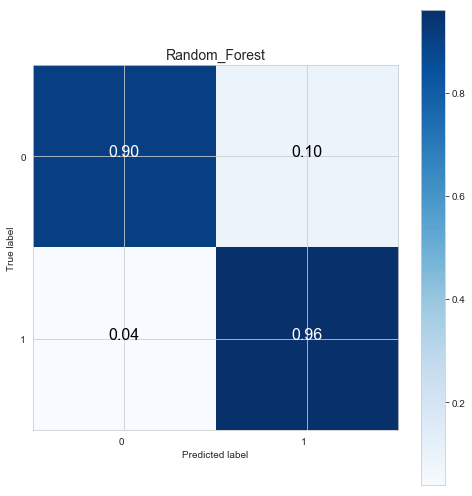

In [103]:
plot_confusion_matrix(y_val, y_pred, normalize=True, title="Random_Forest")

AUC metric for the training and validation sets

In [104]:
auc_val(model_rfc, X_train, X_val)

(0.9999980870909244, 0.9824810606060607)

Feature importance ranking.

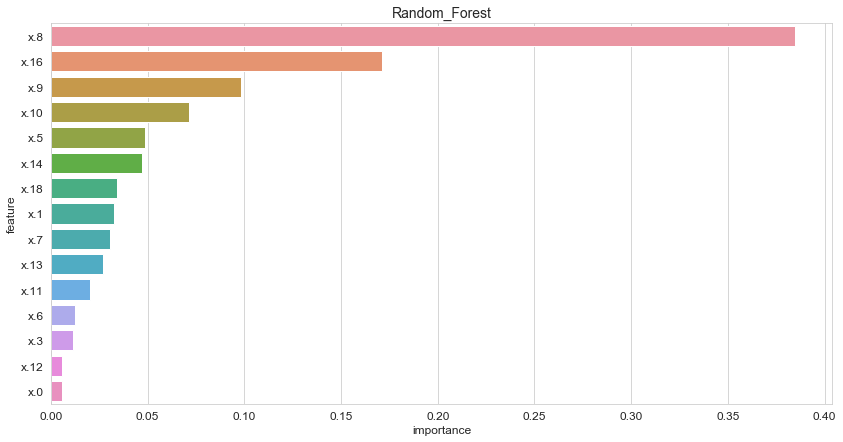

In [105]:
plot_feature_imp(X_train.columns.values, model_rfc.feature_importances_, "Random_Forest")

### XGBoost Classifier

In [106]:
# model
model_xgb =  XGBClassifier(n_estimators=1000, learning_rate=0.1, max_depth=10, eval_metric='auc') 
# Fit the model
model_xgb.fit(X_train, y_train)

y_pred = model_xgb.predict(X_train)
accuracy_score(y_train, np.round(y_pred))

1.0

In [107]:
confusion_matrix(y_train, np.round(y_pred))

array([[2398,    0],
       [   0, 2398]])

Performance on the validation set

In [108]:
y_pred = model_xgb.predict(X_val)
accuracy_score(y_val, np.round(y_pred))

0.8938775510204081

In [109]:
confusion_matrix(y_val, np.round(y_pred))

array([[288,  48],
       [  4, 150]])

Normalized confusion matrix
[[0.85714286 0.14285714]
 [0.02597403 0.97402597]]


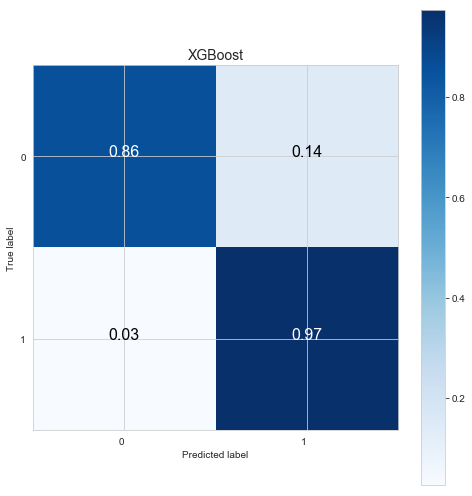

In [110]:
plot_confusion_matrix(y_val, np.round(y_pred), normalize=True, title="XGBoost")

AUC metric for the training and validation sets

In [111]:
auc_val(model_xgb, X_train, X_val)

(1.0, 0.9758329468150896)

Feature importance ranking.

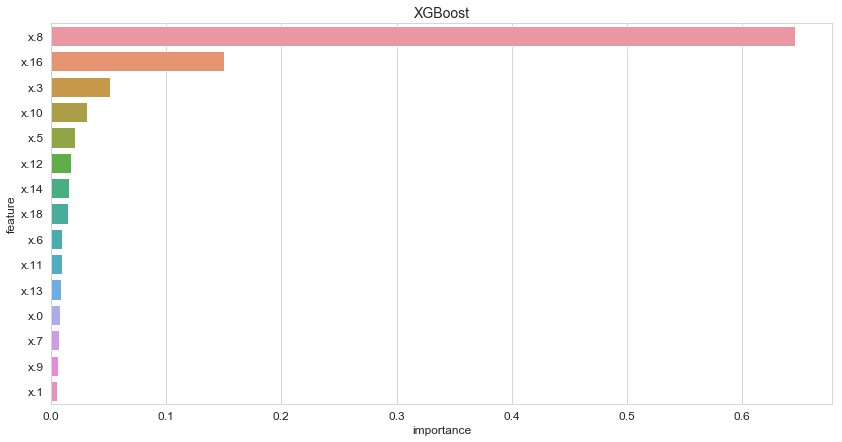

In [112]:
plot_feature_imp(X_train.columns.values, model_xgb.feature_importances_, "XGBoost")

### lightGBM Classifier

In [113]:
cat_fs = ['x.0', 'x.3', 'x.5', 'x.6', 'x.8', 'x.9', 'x.11', 'x.12', 'x.16']

In [114]:
# model
model_lgb = lgb.LGBMClassifier(silent=False)

d_train = lgb.Dataset(X_train, label=y_train)
params = {"max_depth": 10, "learning_rate" : 0.1}

# With Categorical Features
model_lgb = lgb.train(params, d_train, 1000, categorical_feature = cat_fs)

# Without Categorical Features
#model_lgb = lgb.train(params, d_train, 500)

y_pred = model_lgb.predict(X_train)

accuracy_score(y_train, np.round(y_pred))


/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['x.0', 'x.11', 'x.12', 'x.16', 'x.3', 'x.5', 'x.6', 'x.8', 'x.9']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


1.0

Performance on the validation set

In [115]:
y_pred = model_lgb.predict(X_val)
accuracy_score(y_val, np.round(y_pred))

0.8918367346938776

In [116]:
confusion_matrix(y_val, np.round(y_pred))

array([[289,  47],
       [  6, 148]])

Normalized confusion matrix
[[0.86011905 0.13988095]
 [0.03896104 0.96103896]]


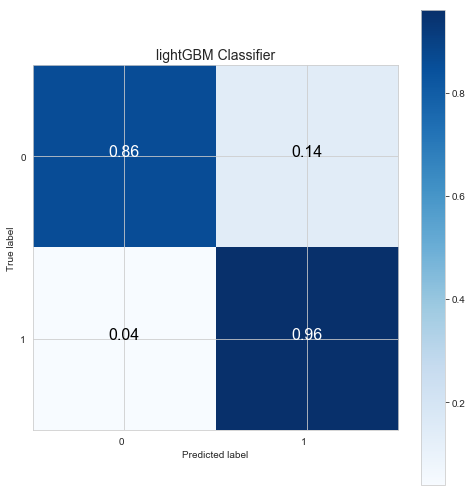

In [117]:
plot_confusion_matrix(y_val, np.round(y_pred), normalize=True, title="lightGBM Classifier")

AUC metric for the training and validation sets

In [118]:
auc_val_lgbm(model_lgb, X_train, X_val)

(1.0, 0.9714556277056278)

Feature importance ranking.

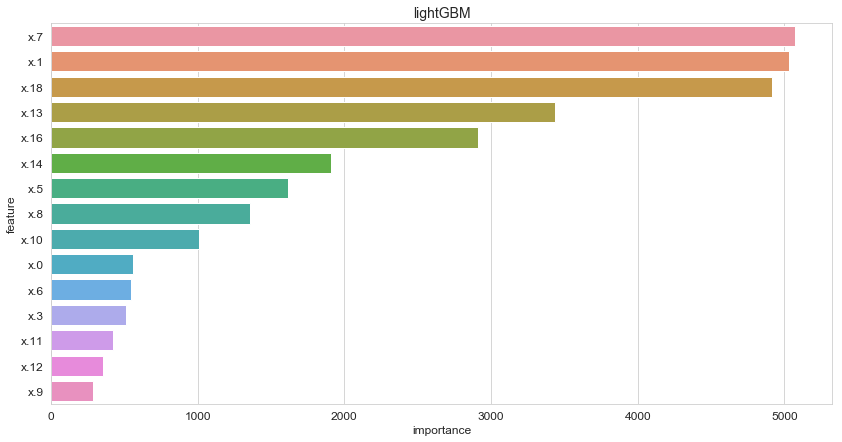

In [119]:
plot_feature_imp(X_train.columns.values, model_lgb.feature_importance(), "lightGBM")

### CatBoost Classifier

In [78]:
cat_features_index = [6,7,8,9,10,11,12,13,14]  #8,9 x.5 x.6

In [79]:
# model
model_cb = CatBoostClassifier(eval_metric="AUC", depth=10, iterations= 1000, learning_rate= 0.07, silent=True)

# With Categorical Features
model_cb.fit(X_train,y_train, cat_features= cat_features_index)
# Without Categorical Features
#model_cb.fit(X_train,y_train)

#y_pred = model_cb.predict(X_train)
#accuracy_score(y_train, y_pred)

In [80]:
y_pred = model_cb.predict(X_train)
accuracy_score(y_train, y_pred)

0.9995829858215179

In [81]:
confusion_matrix(y_train, y_pred)

array([[2396,    2],
       [   0, 2398]])

Performance on the validation set

In [82]:
y_pred = model_cb.predict(X_val)
accuracy_score(y_val, y_pred)

0.9183673469387755

In [83]:
confusion_matrix(y_val, y_pred)

array([[301,  35],
       [  5, 149]])

The confusion matrix looks fairly good since most instances are on the main diagonal which means that they are classified correctly.

Normalized confusion matrix
[[0.89583333 0.10416667]
 [0.03246753 0.96753247]]


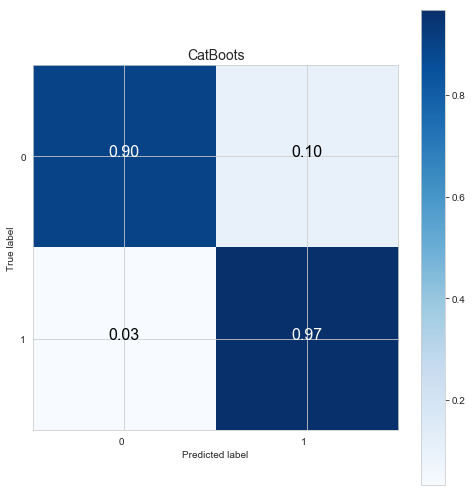

In [90]:
plot_confusion_matrix(y_val, y_pred, normalize=True, title="CatBoots")

AUC metric for the training and validation sets

In [85]:
auc_val(model_cb, X_train, X_val)

(1.0, 0.9634160482374768)

Feature importance ranking.

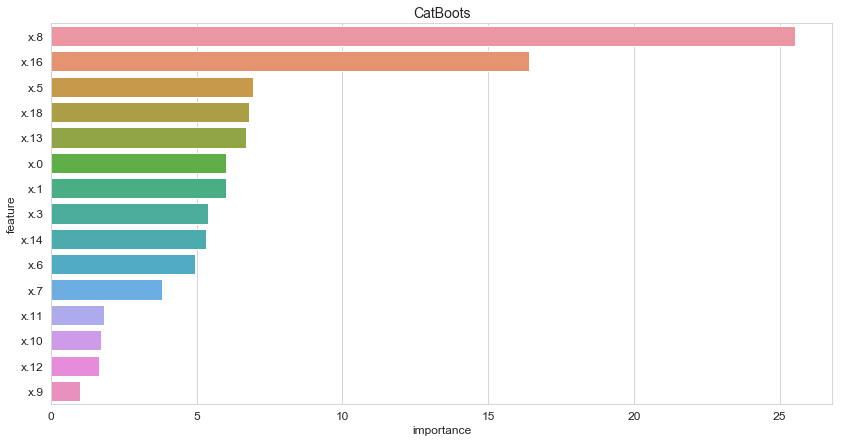

In [91]:
plot_feature_imp(X_train.columns.values, 
                 model_cb.get_feature_importance(Pool(X_train, label=y_train, cat_features= cat_features_index)), 
                 "CatBoots")

This analysis presented a tree-based approach to classify 2 types of classes in an imbalanced dataset.
